# Gaussian Process on the Toy dataset, using Inducing Points

# Github

In [ ]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Project18/GPs


# Imports

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 8.9 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/datasets


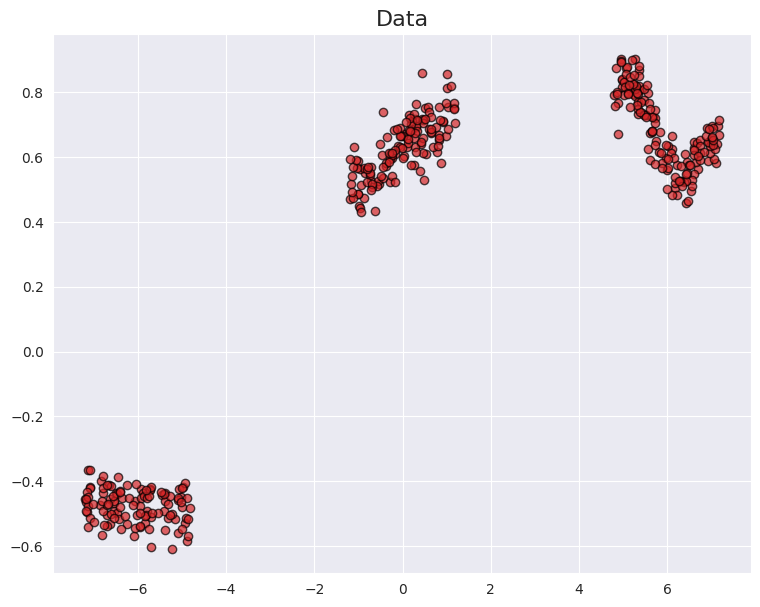

Concrete_Data.xls  PowerPlant_Data.xlsx  toy_data.npy  wiggle.ipynb
concrete.ipynb	   powerPlant.ipynb	 toy.ipynb


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline
%load_ext autoreload
%autoreload 2
%run ../datasets/toy.ipynb # Run the toy notebook which is in the datasets folder(toy dataset)


# Training data from toy.ipynb

In [35]:
xTrain, yTrain = x, y # x, y are defined in ../datasets/toy.ipynb
xTrain, yTrain = torch.from_numpy(xTrain), torch.from_numpy(yTrain) # Convert them to tensors
print(len(xTrain))

400


# Inducing Points

In [39]:
amount_of_points = 300
inducingPointsX = xTrain[:amount_of_points] # Choose how many points to pick
inducingPointsY = yTrain[:amount_of_points] # Choose how many points to pick

# Test points
inducingPointsX_test = xTrain[amount_of_points:]
inducingPointsY_test = yTrain[amount_of_points:]
print(len(inducingPointsX), len(inducingPointsX_test))

300 100


# The GP model

In [40]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x_Inducing, y_Inducing, likelihood):
        super(GPModel, self).__init__(x_Inducing, y_Inducing, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [41]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# Training Function

In [42]:
import os
def train(model, xTrain, yTrain): # Train the model on training data: xTrain, yTrain

  smoke_test = ('CI' in os.environ)
  training_iter = 2 if smoke_test else 250


  # Find optimal model hyperparameters
  model.train()
  model.likelihood.train()

  # Use the adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  # Train without printing to ensure the training method is as fast as possible
  for i in range(training_iter):
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(xTrain)
      # Calc loss and backprop gradients
      loss = -mll(output, yTrain)
      loss.backward()
      optimizer.step()


# Train the Model#

In [43]:
%time train(model, inducingPointsX, inducingPointsY)

CPU times: user 3.49 s, sys: 9.8 ms, total: 3.5 s
Wall time: 3.51 s


# Root Mean Square Error(RMSE)

In [45]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(model(inducingPointsX_test))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
    mean = observed_pred.mean.numpy()

squared_error = (mean - inducingPointsY_test.numpy())**2 # Compute the squared error

mean_SE = squared_error.mean() # Compute the mean squared error

root_MSE = np.sqrt(mean_SE) # Compute the square root of the mean squared error

root_MSE

0.05367861445098253

# Test data

In [46]:
# Observing the plot of the toy dataset, x varies between -7-7
xTest = torch.linspace(-10, 10, 50)

# The posterior mean, variance and Covariance Matrix

In [47]:
model.eval() # eval mode is for computing predictions through the model posterior
f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
f_mean = f_preds.mean # Predictive mean
f_var = f_preds.variance # Predictive variance
f_covar = f_preds.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean.size())
print()
print("Variance Dimension: ", f_var.size())
print()
print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([50])

Variance Dimension:  torch.Size([50])

CovMatrix Dimension  torch.Size([50, 50])


# Plots of samples from the GP

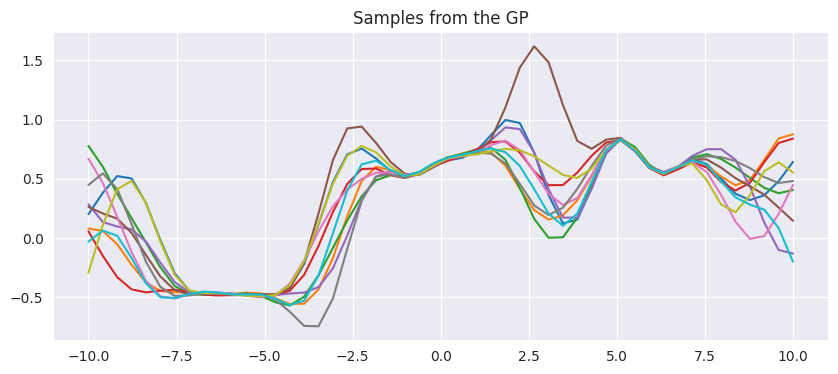

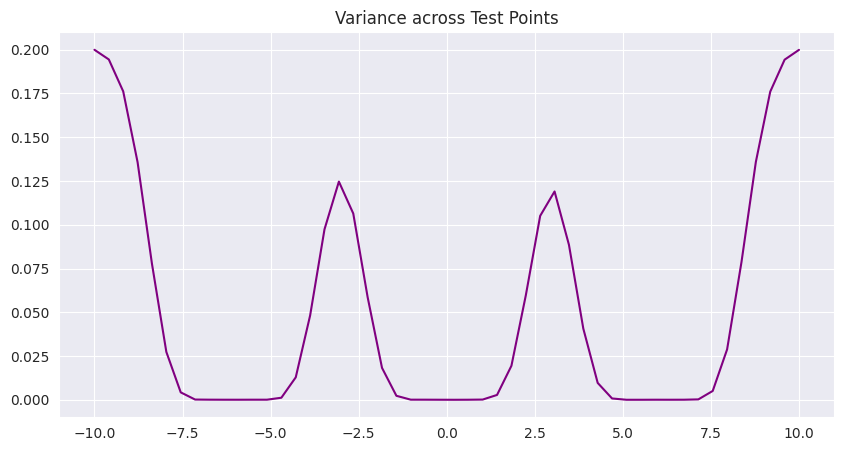

In [48]:
# Convert to numpy
xTestPlot = xTest.detach().numpy()
f_meanPlot = f_mean.detach().numpy()
f_varPlot = f_var.detach().numpy()
# Plot samples from the GP
plt.figure(figsize=(10, 4))
for i in range(10):  # Generate 20 samples
    f_sample = f_preds.sample().detach().numpy()
    plt.plot(xTestPlot, f_sample)
plt.title('Samples from the GP')
plt.show()
# Plot variance
plt.figure(figsize=(10, 5))
plt.plot(xTestPlot, f_varPlot, 'purple')
plt.title('Variance across Test Points')
plt.show()

# Predictive Distribution

In [49]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

# Plot with RBF kernel

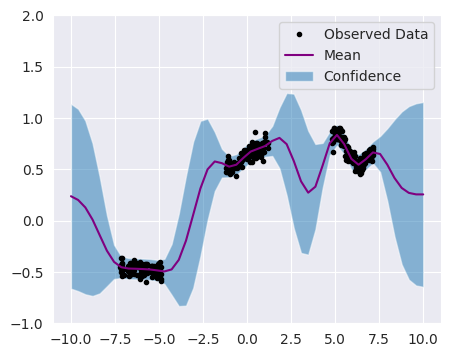

In [50]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(5, 4))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(inducingPointsX.numpy(), inducingPointsY.numpy(), 'k.')
    # Plot predictive means as purple line
    ax.plot(xTest.numpy(), observed_pred.mean.numpy(), 'purple')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# Compare different amount of points


Inducing Points:  5
CPU times: user 1.14 s, sys: 8.69 ms, total: 1.15 s
Wall time: 1.19 s

Inducing Points:  10


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


CPU times: user 1.09 s, sys: 7.16 ms, total: 1.1 s
Wall time: 1.12 s

Inducing Points:  50
CPU times: user 1.23 s, sys: 9.66 ms, total: 1.24 s
Wall time: 1.27 s

Inducing Points:  100
CPU times: user 1.12 s, sys: 8.59 ms, total: 1.13 s
Wall time: 1.14 s

Inducing Points:  200
CPU times: user 1.83 s, sys: 12.8 ms, total: 1.84 s
Wall time: 1.85 s

Inducing Points:  400
CPU times: user 6.15 s, sys: 68.7 ms, total: 6.22 s
Wall time: 7 s


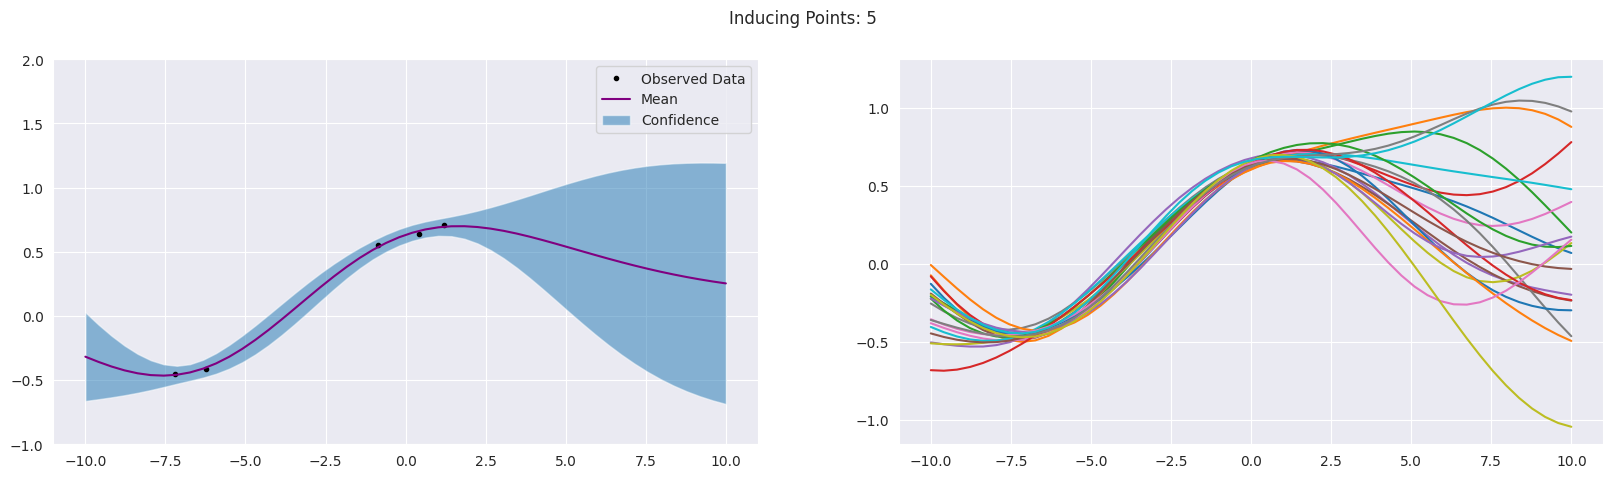

<Figure size 1000x400 with 0 Axes>

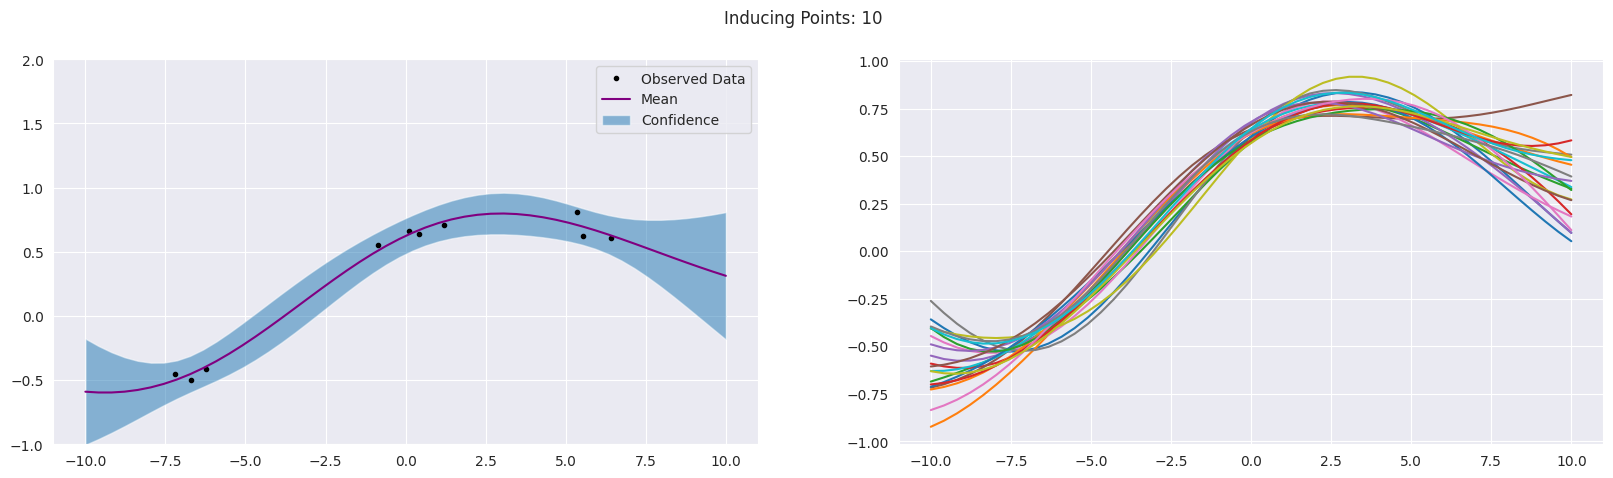

<Figure size 1000x400 with 0 Axes>

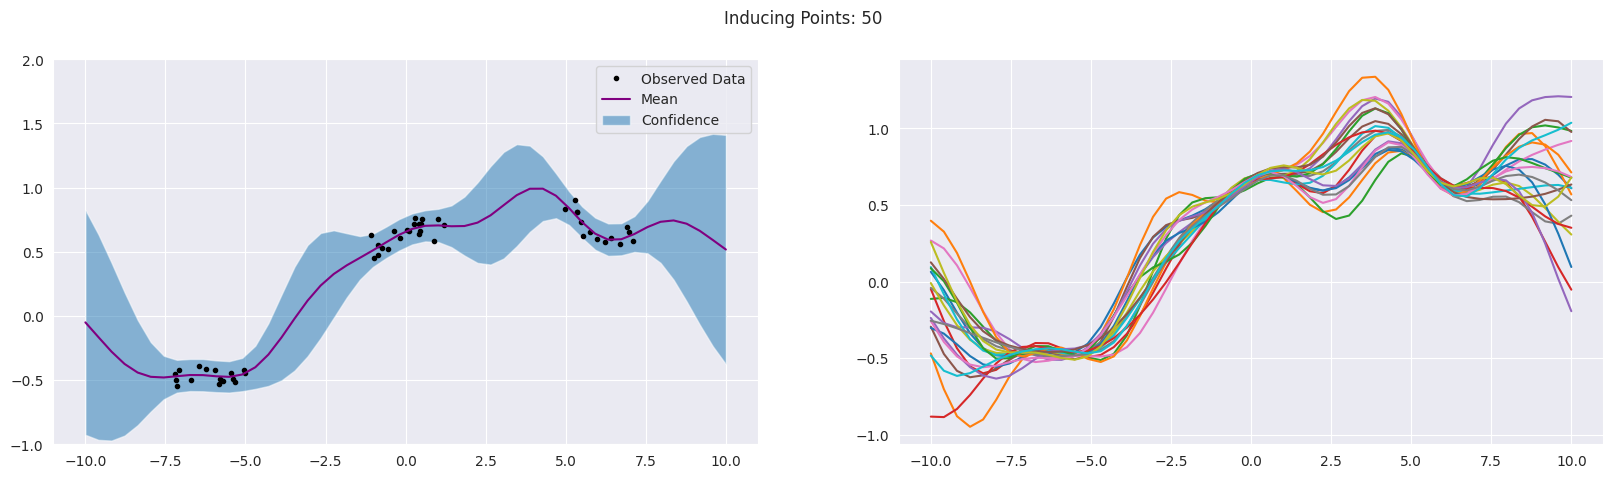

<Figure size 1000x400 with 0 Axes>

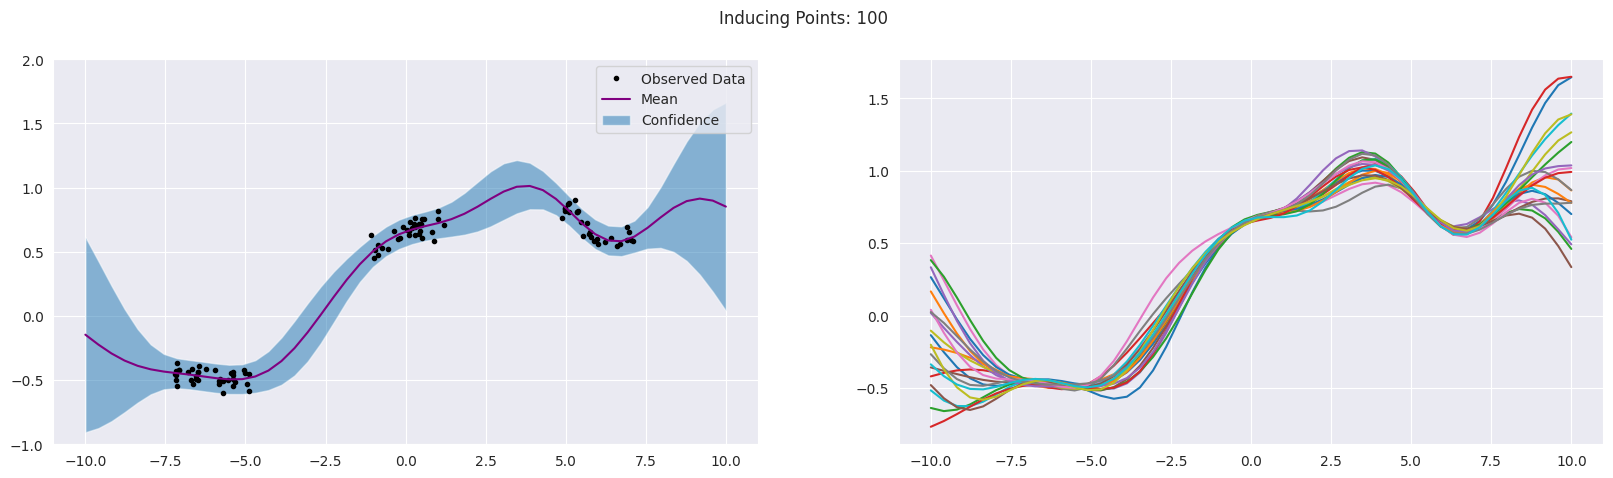

<Figure size 1000x400 with 0 Axes>

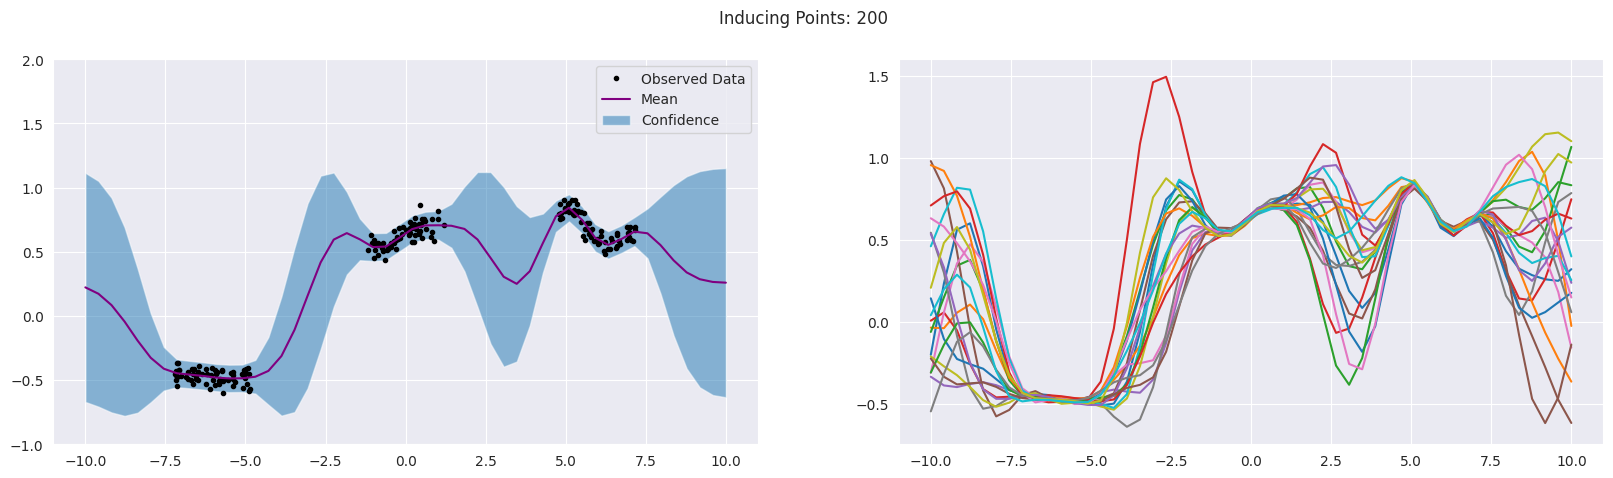

<Figure size 1000x400 with 0 Axes>

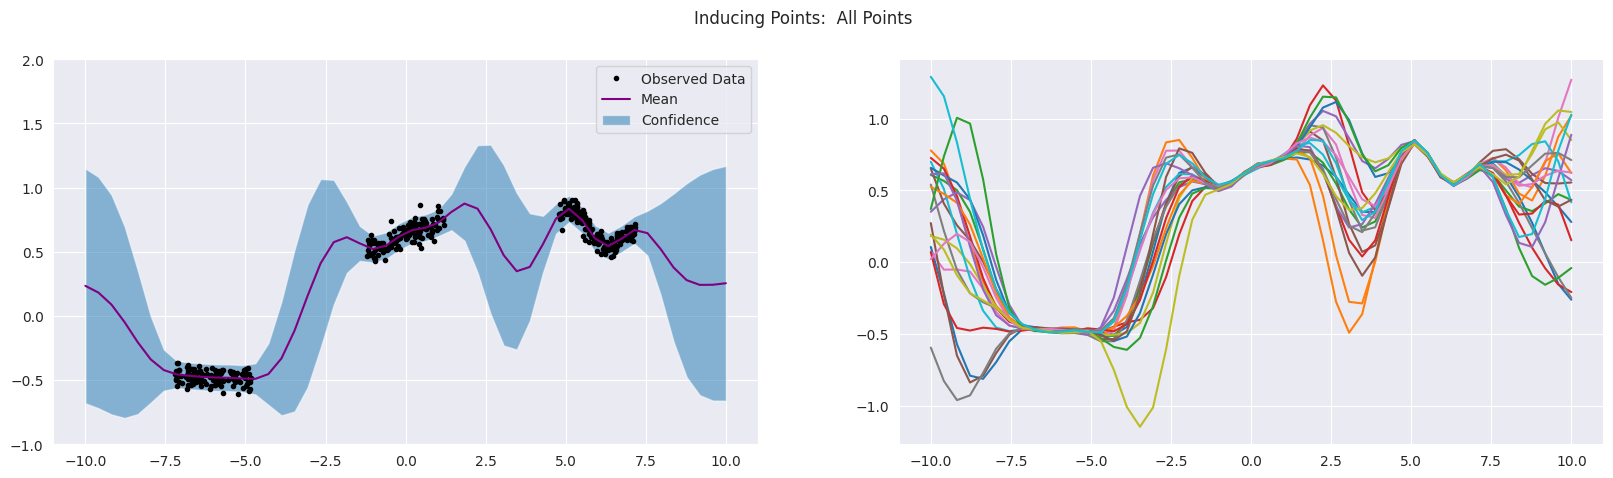

<Figure size 1000x400 with 0 Axes>

In [51]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPoints(listOfPoints):
  maxPoints = len(xTrain) # The max amount of points in training points
  for points in listOfPoints:
    inducingPointsX = xTrain[:points] # Choose how many points to pick
    inducingPointsY = yTrain[:points] # Choose how many points to pick

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    print()
    print("Inducing Points: ", points)

    %time train(model, inducingPointsX, inducingPointsY) # Train the model
    # Plot
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()



    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
        observed_pred = likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

        f, ax = plt.subplots(1, 2, figsize=(20, 5))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black dots
        ax[0].plot(inducingPointsX.numpy(), inducingPointsY.numpy(), 'k.')
        # Plot predictive means as purple line
        ax[0].plot(xTest.numpy(), observed_pred.mean.numpy(), 'purple')
        # Shade between the lower and upper confidence bounds
        ax[0].fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax[0].set_ylim([-1, 2])
        ax[0].legend(['Observed Data', 'Mean', 'Confidence'])

        f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
        f_mean = f_preds.mean # Predictive mean
        f_var = f_preds.variance # Predictive variance
        xTestPlot = xTest.detach().numpy()
        f_meanPlot = f_mean.detach().numpy()
        f_varPlot = f_var.detach().numpy()
        # Plot samples from the GP
        plt.figure(figsize=(10, 4))
        for i in range(20):  # Generate 20 samples
            f_sample = f_preds.sample().detach().numpy()
            ax[1].plot(xTestPlot, f_sample)
        if(points == maxPoints):
           f.suptitle('Inducing Points:  All Points')  # If all training points are used
        else:
          f.suptitle('Inducing Points: '+ str(points)) # Else print current amount of points

severalInducingPoints([5,10,50,100,200,400])


# Use K-means clustering to choose inducing points

# function for calculating inducing points

In [52]:
def kmeansPoints(x, y, N): # The dataset (X,Y) and the N amount of inducing points wished
  # Normalize training points
  x_mean = x.mean(axis = 0) # mean for each feature
  x_std = x.std(axis = 0) # std for each feature
  x_normalized = (x-x_mean) / x_std # Normalize
  RS = 0 # Random state
  xTrain_KMeans = x_normalized.reshape(-1,1)
  kmeans = KMeans(n_clusters=N, n_init=1, random_state=RS ).fit(xTrain_KMeans) # Apply K-means clustering on the normalized training data
  xInducing = kmeans.cluster_centers_ # Use the centers of the clusters as the inducing points
  # To get the corresponding y values for each inducing point, compute the closest data point.
  closest_indices, _ = pairwise_distances_argmin_min(xInducing, xTrain_KMeans) # Will return indexes of xTrain_KMeans which is most similar(the same in this case) as xInducing
  yInducing = y[closest_indices] # Choose the corresponding y values for the inducing points
  xInducing = x[closest_indices] # We want to return the non-normalized x
  return xInducing, yInducing

# Compare different amount of inducing points


Inducing Points:  4
CPU times: user 7.44 ms, sys: 23 µs, total: 7.46 ms
Wall time: 7.31 ms
CPU times: user 868 ms, sys: 3.97 ms, total: 872 ms
Wall time: 884 ms

Inducing Points:  6
CPU times: user 6.78 ms, sys: 992 µs, total: 7.77 ms
Wall time: 8.06 ms


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


CPU times: user 778 ms, sys: 3.13 ms, total: 781 ms
Wall time: 787 ms

Inducing Points:  8
CPU times: user 4.69 ms, sys: 0 ns, total: 4.69 ms
Wall time: 4.71 ms


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


CPU times: user 828 ms, sys: 16.2 ms, total: 845 ms
Wall time: 854 ms

Inducing Points:  10
CPU times: user 4.61 ms, sys: 990 µs, total: 5.6 ms
Wall time: 5.72 ms


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


CPU times: user 822 ms, sys: 5.1 ms, total: 827 ms
Wall time: 830 ms

Inducing Points:  12
CPU times: user 5.47 ms, sys: 0 ns, total: 5.47 ms
Wall time: 5.49 ms


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


CPU times: user 829 ms, sys: 7.01 ms, total: 836 ms
Wall time: 845 ms

Inducing Points:  100
CPU times: user 21.6 ms, sys: 0 ns, total: 21.6 ms
Wall time: 21.6 ms


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


CPU times: user 1.05 s, sys: 6.13 ms, total: 1.05 s
Wall time: 1.06 s


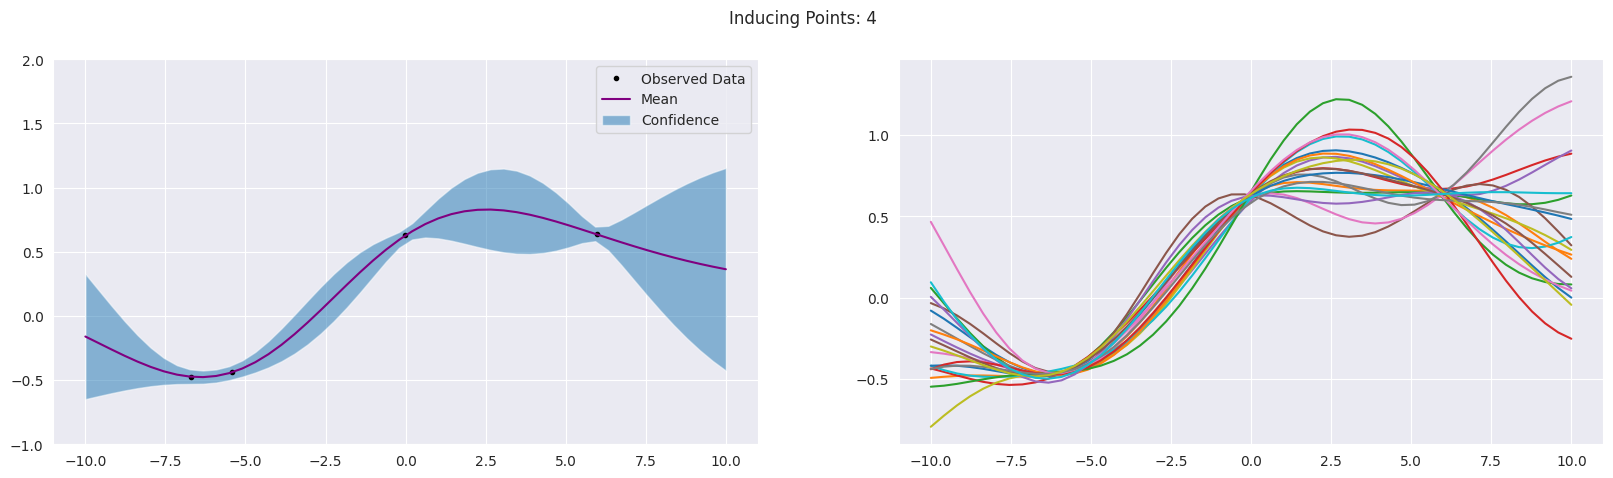

<Figure size 1000x400 with 0 Axes>

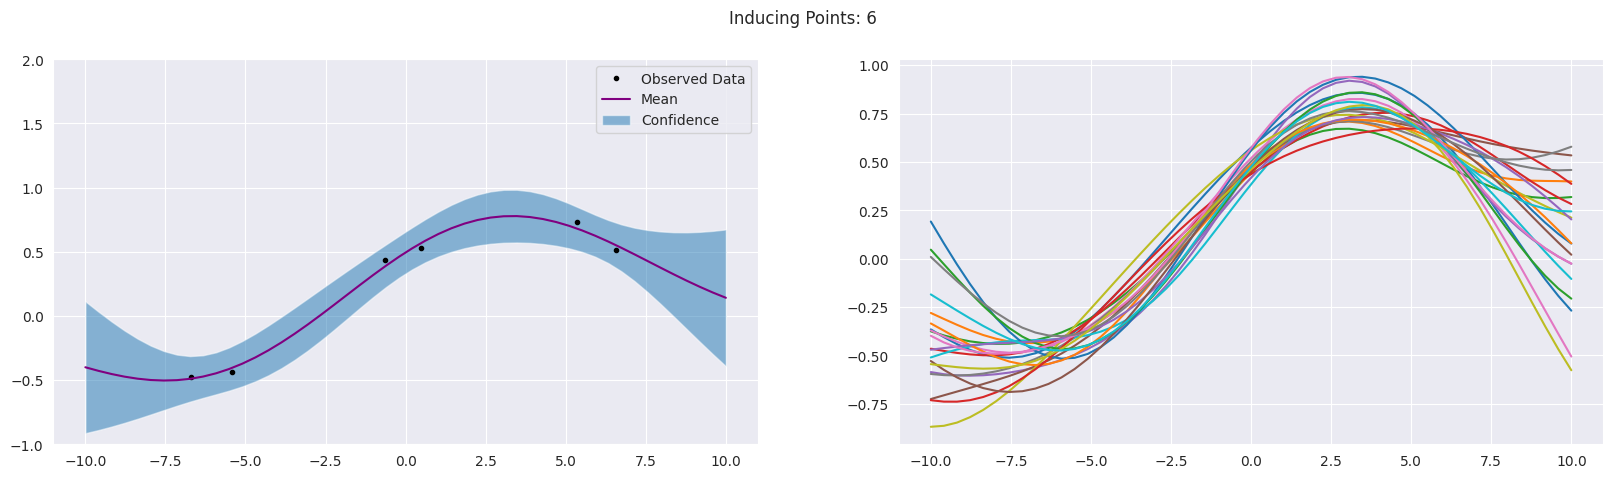

<Figure size 1000x400 with 0 Axes>

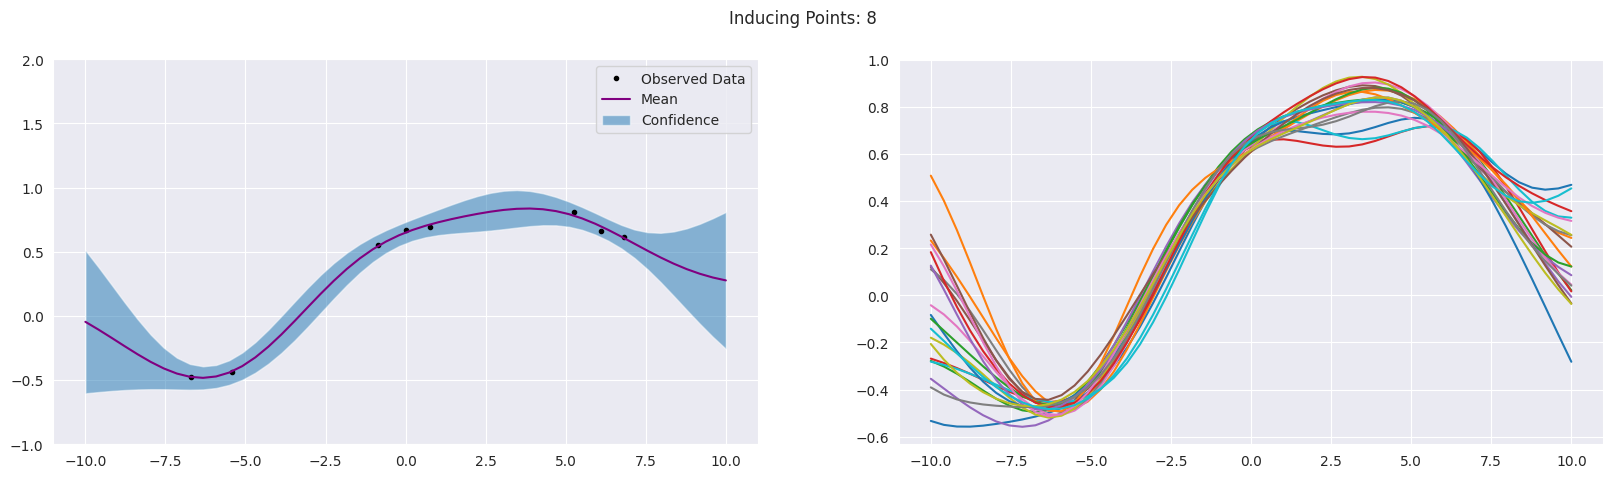

<Figure size 1000x400 with 0 Axes>

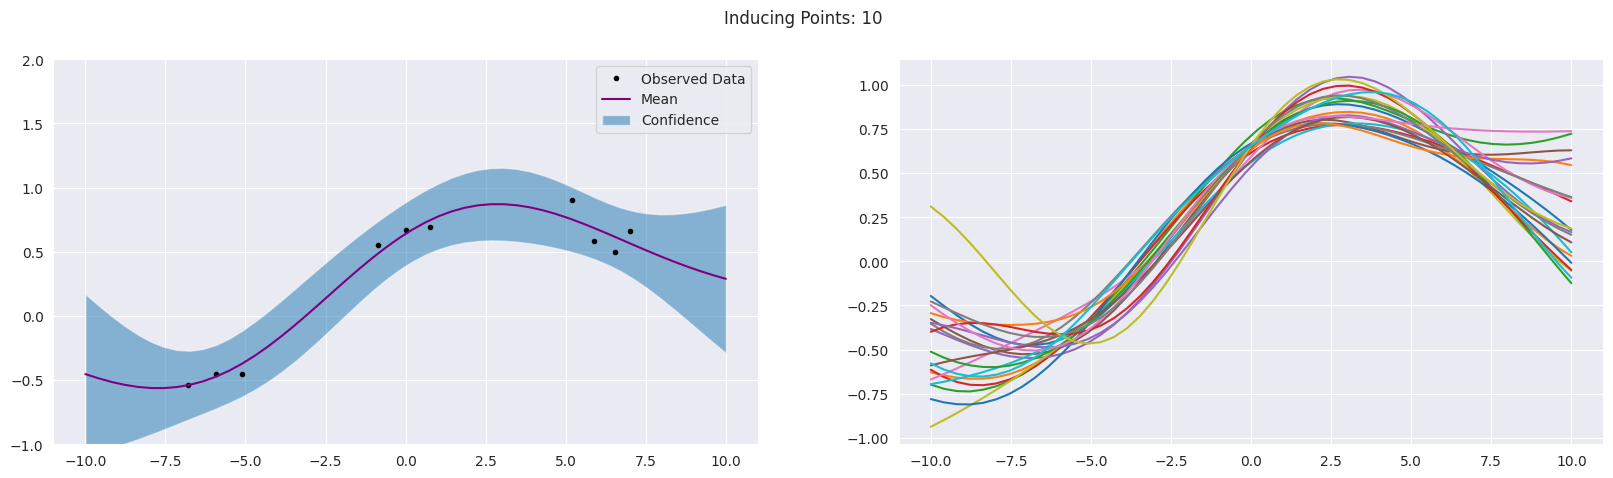

<Figure size 1000x400 with 0 Axes>

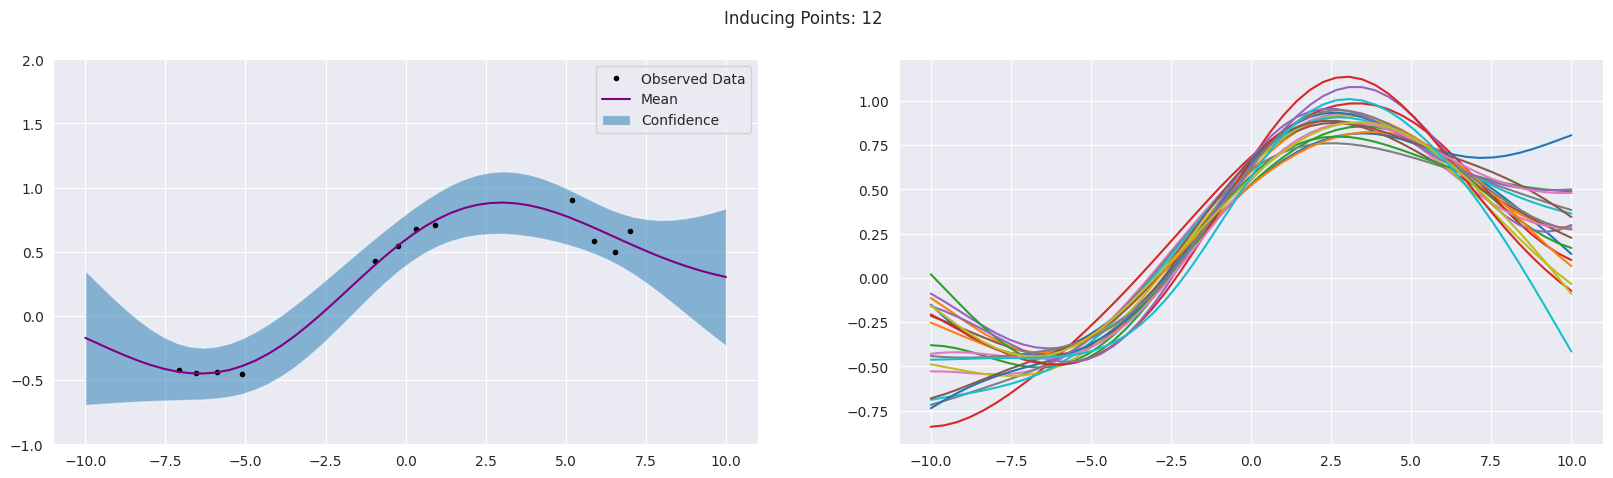

<Figure size 1000x400 with 0 Axes>

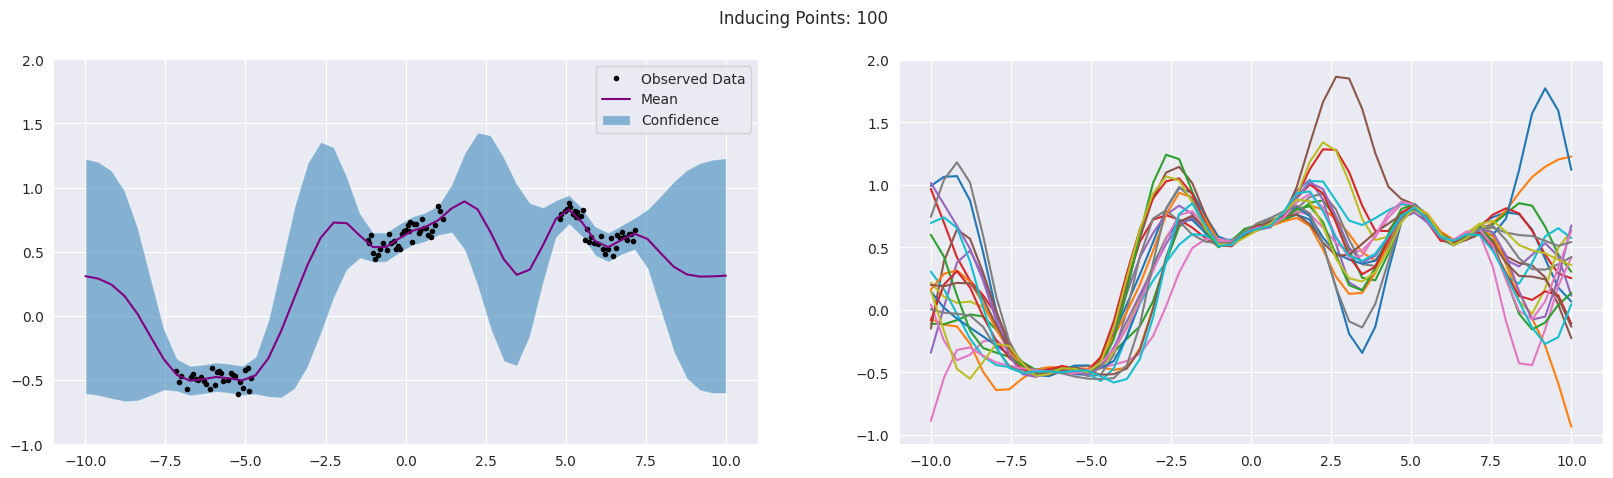

<Figure size 1000x400 with 0 Axes>

In [53]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPointsKmeans(listOfPoints):
  maxPoints = len(xTrain) # The max amount of points in training points
  for points in listOfPoints:
    print()
    print("Inducing Points: ", points)
    inducingPointsX, inducingPointsY = %time kmeansPoints(xTrain, yTrain, points) # Choose how many points to pick

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()


    %time train(model, inducingPointsX, inducingPointsY) # Train the model
    # Plot
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
        observed_pred = likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

        f, ax = plt.subplots(1, 2, figsize=(20, 5))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black dots
        ax[0].plot(inducingPointsX.numpy(), inducingPointsY.numpy(), 'k.')
        # Plot predictive means as purple line
        ax[0].plot(xTest.numpy(), observed_pred.mean.numpy(), 'purple')
        # Shade between the lower and upper confidence bounds
        ax[0].fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax[0].set_ylim([-1, 2])
        ax[0].legend(['Observed Data', 'Mean', 'Confidence'])

        f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
        f_mean = f_preds.mean # Predictive mean
        f_var = f_preds.variance # Predictive variance
        xTestPlot = xTest.detach().numpy()
        f_meanPlot = f_mean.detach().numpy()
        f_varPlot = f_var.detach().numpy()
        # Plot samples from the GP
        plt.figure(figsize=(10, 4))
        for i in range(20):  # Generate 20 samples
            f_sample = f_preds.sample().detach().numpy()
            ax[1].plot(xTestPlot, f_sample)
        if(points == maxPoints):
           f.suptitle('Inducing Points:  All Points')  # If all training points are used
        else:
          f.suptitle('Inducing Points: '+ str(points)) # Else print current amount of points

severalInducingPointsKmeans([4,6,8,10,12,100])